# IMPORT LIBRARIES

In [1]:
import os
import gc
import re
import cv2
import sys
import glob

import numpy  as np
import pandas as pd
from numpy.fft import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
import matplotlib.style  as style
import seaborn as sns
from tqdm  import tqdm


from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings('ignore')

# HELPER FUNCTIONS

In [2]:
models = [LogisticRegression, RandomForestClassifier, SVC]
models_string = ['LogisticRegression', 'RandomForestClassifier', 'SVC']
models_hyper_params = [{'penalty': ['l1', 'l2'], 'solver':['lbfgs', 'liblinear'], 'max_iter': [1000]},
                       {"n_estimators": [10,50,100], "criterion": ['gini', 'entropy'], 'max_depth':[10,15,30]},
                       {'C': [0.1, 10, 100], 'gamma': [0.01, 0.1], 'kernel': ['linear', 'poly']}]

In [3]:
LR_accuracies = []
RF_accuracies = []
SVC_accuracies = []

def append_accuracy(model_string, test_acc):        
    if model_string == 'LogisticRegression':
        LR_accuracies.append(test_acc)
    elif model_string == 'RandomForestClassifier':
        RF_accuracies.append(test_acc)
    elif model_string == 'SVC':
        SVC_accuracies.append(test_acc)
    else:
        pass


In [4]:
def evaluate_predictions(train_df, test_df, train_y, test_y):
    index = 0
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5), sharey=True)
    
    for m, m_s, m_hp in zip(models, models_string, models_hyper_params):  
        # find best param values for each model and check accuracies
        gs = GridSearchCV(m(),m_hp)
        gs.fit(train_df, train_y)
        m_best_params = gs.best_params_

        print(m_best_params)

        m_best_estimator = gs.best_estimator_

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=25)
        # cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=25)
        scores = cross_val_score(m_best_estimator, train_df, train_y, scoring='accuracy', cv=cv, n_jobs=-1)
        acc = round(np.mean(scores), 2)


        ypred_cv = m_best_estimator.predict(test_df)
        test_acc = round(np.mean(accuracy_score(test_y, ypred_cv)), 2)
        test_auroc = round(np.mean(roc_auc_score(test_y, ypred_cv)), 2)

        print(f"Model: {m_s} >> CV Score: {acc}, Test Accuracy: {test_acc}, Test AUC: {test_auroc}")
        print("\n")
        
        append_accuracy(m_s, test_acc)
        
        cm = confusion_matrix(test_y,ypred_cv)
        sns.heatmap(cm,annot=True, ax=axes[index])
        axes[index].set_title(m_s)
        
        index += 1
        
    plt.show()
        

In [5]:
def extract_label(file_list):
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        labels.append(current_label[0])
    return(labels)

In [6]:
def extract_mask_path(file_list, dataset):
    if dataset == 'montgomery':
        MASK_DIR = '../input/montgomery-mask'
    else:
        MASK_DIR = '../input/shenzen-mask'
            
    mask_paths = []
    for file in tqdm(file_list):
        path, fname = os.path.split(file)
        
        if dataset == 'montgomery':
            fname = fname
        else:
            fname_parts = fname.split('.')
            fname = "".join([fname_parts[0], '_mask.', fname_parts[1]])
        
        mpath = os.path.join(MASK_DIR, fname)
        
        mask_paths.append(mpath)
        
    return mask_paths

In [7]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# IMPORT DATASET

In [8]:
filelist_montgommery = glob.glob('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/*.png')
filelist_shenzen     = glob.glob('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')

In [9]:
filelist = filelist_montgommery + filelist_shenzen

In [10]:
labels = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 217772.79it/s]


In [11]:
full_data = pd.DataFrame(filelist, columns=['filepath'])
full_data['target'] = labels
full_labels = pd.DataFrame(full_data.pop('target'), columns=['target'])

# Preview dataframe
full_data.head()

filepath
0  ../input/pulmonary-chest-xray-abnormalities/Mo...
1  ../input/pulmonary-chest-xray-abnormalities/Mo...
2  ../input/pulmonary-chest-xray-abnormalities/Mo...
3  ../input/pulmonary-chest-xray-abnormalities/Mo...
4  ../input/pulmonary-chest-xray-abnormalities/Mo...

# EXPLORATORY DATA ANALYSIS

In [12]:
def plot_images_color_bar(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        img = cv2.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
        
        if preprocessing:
            img = preprocessing(img)
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(gray) 
        plt.colorbar()
        nth_subplot += 1
    
    plt.show()

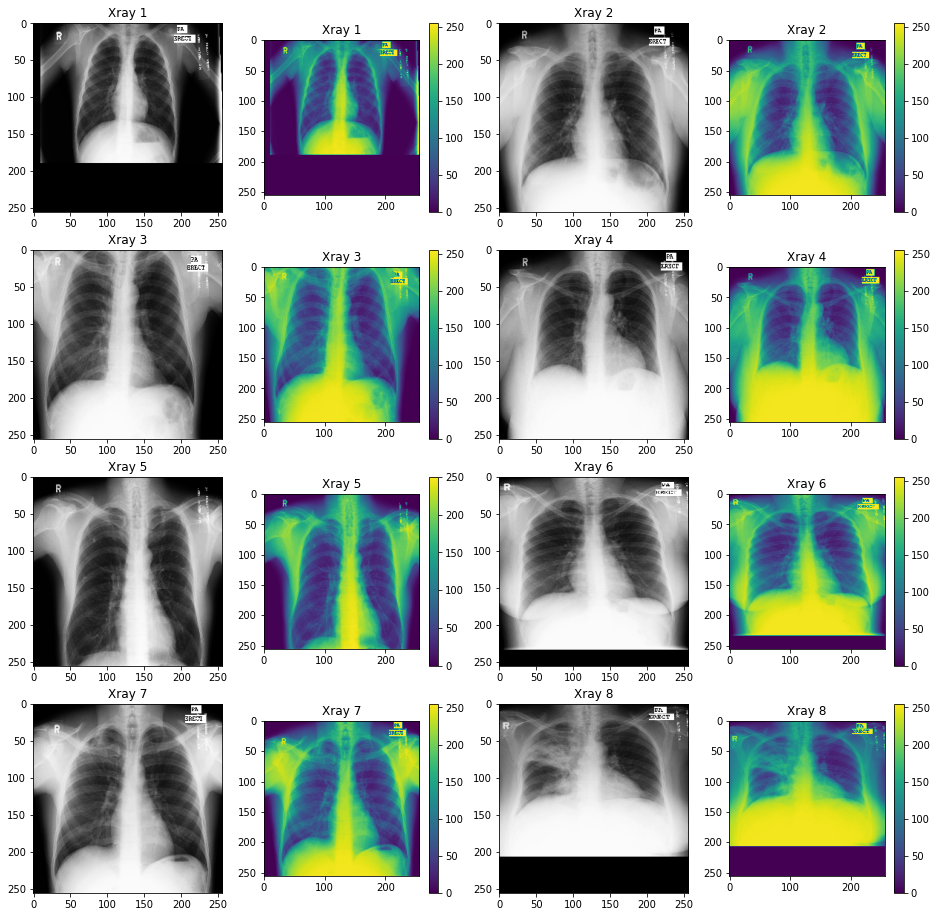

In [13]:
plot_images_color_bar(full_data, rows=4, columns = 2, figsize = (16, 16), resize=(256,256))

In [14]:
def plot_images_hist(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        img = cv2.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
        
        if preprocessing:
            img = preprocessing(img)
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Hist "+str(i+1))
        plt.hist(gray.ravel(), bins=256, range=(0, 255), fc='k', ec='k')  
        nth_subplot += 1
    
    plt.show()

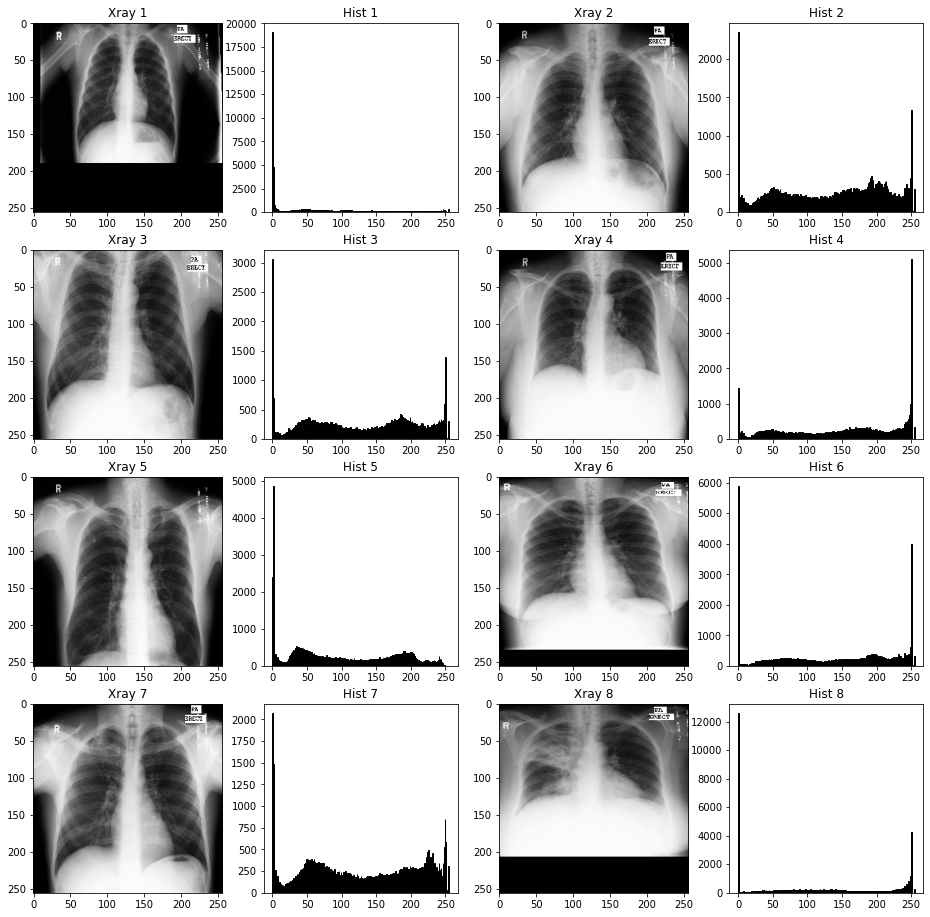

In [15]:
plot_images_hist(full_data, rows=4, columns = 2, figsize = (16, 16), resize=(256,256))

# BENCHMARK - UNPROCESSED IMAGES

In [16]:
def plot_original_images(image_dataframe, rows=4, columns=4, figsize=(16, 16), resize=(128,128)):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []

    for i in range(rows * columns):
        img = cv2.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        ax.append(fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(img, cmap='gray')
    
    plt.show()

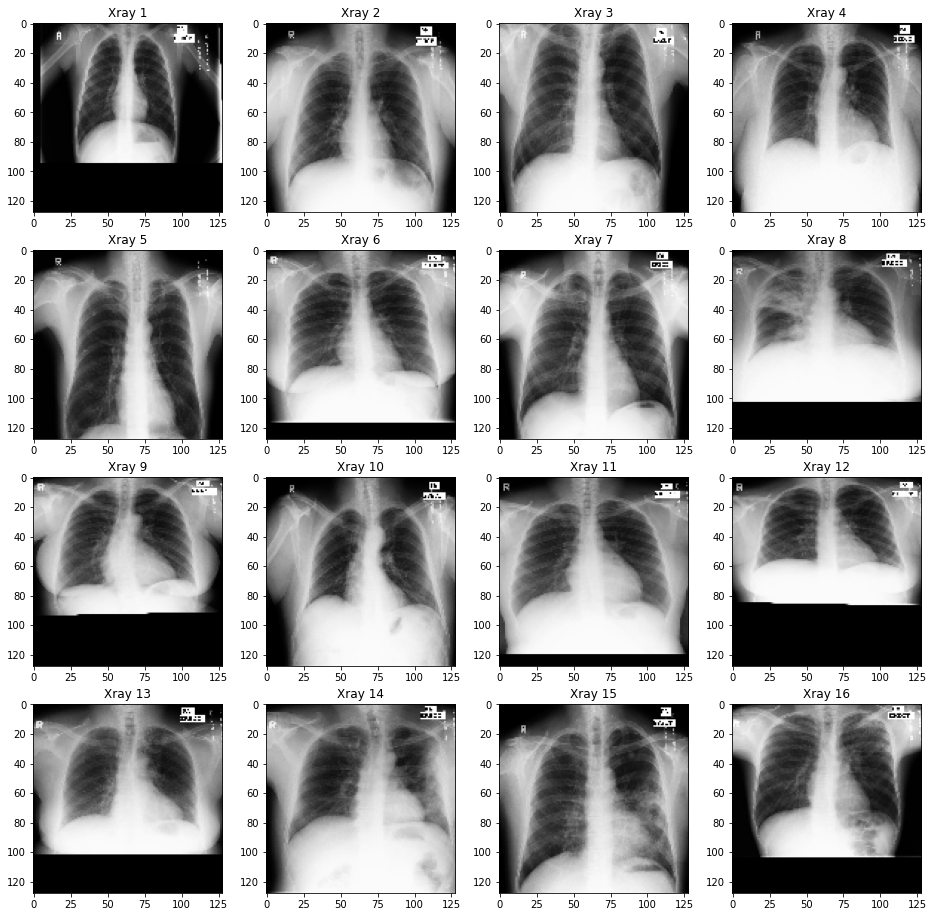

In [17]:
plot_original_images(full_data, rows=4, columns=4)

In [18]:
def load_image(image_path, image_dims = (128,128), grayscale=True, flatten=True, interpolation = cv2.INTER_AREA):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, image_dims, interpolation = interpolation)
    
    if grayscale:
        resized_image = resized_image[:,:,0]
    
    if flatten:
        resized_image = resized_image.flatten()
    
    return(resized_image)

In [19]:
def create_flattened_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        current = load_image(im_path).tolist()
        current = pd.DataFrame(current).T
        result  = result.append(current)
    
    return(result)

In [20]:
full_data_flat = create_flattened_dataframe(full_data)

100%|██████████| 800/800 [02:41<00:00,  4.94it/s]


In [21]:
# Split data into training and testing sets
train_df,test_df,train_y,test_y = train_test_split(full_data_flat,
                                                   full_labels['target'],
                                                   stratify = full_labels['target'],
                                                   test_size = 0.2,
                                                   random_state = 25)

{'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Model: LogisticRegression >> CV Score: 0.8, Test Accuracy: 0.79, Test AUC: 0.79


{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.82, Test Accuracy: 0.78, Test AUC: 0.78


{'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Model: SVC >> CV Score: 0.81, Test Accuracy: 0.78, Test AUC: 0.78




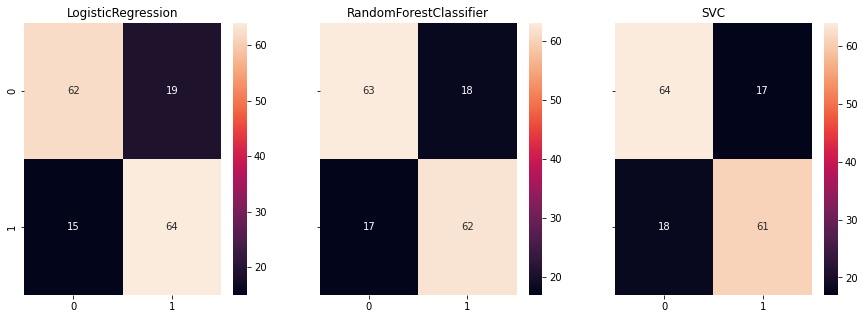

In [22]:
evaluate_predictions(train_df, test_df, train_y, test_y)

# BENCHMARK - UNPROCESSED IMAGES AFTER PCA FEATURE SELECTION

In [23]:
min_max_scaler = MinMaxScaler()
full_data_scaled_flat = min_max_scaler.fit_transform(full_data_flat)

In [24]:
pca = decomposition.PCA(n_components=500)
full_data_pca_flat = pca.fit_transform(full_data_scaled_flat)

In [25]:
full_data_norm_flat = normalize_data(full_data_pca_flat)

In [26]:
pca_fd_train_df,pca_fd_test_df,pca_fd_train_y,pca_fd_test_y = train_test_split(full_data_norm_flat,
                                                                    full_labels['target'],
                                                                    stratify = full_labels['target'],
                                                                    test_size  = 0.2,
                                                                    random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Model: LogisticRegression >> CV Score: 0.78, Test Accuracy: 0.74, Test AUC: 0.74


{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.69, Test Accuracy: 0.69, Test AUC: 0.69


{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Model: SVC >> CV Score: 0.81, Test Accuracy: 0.78, Test AUC: 0.78




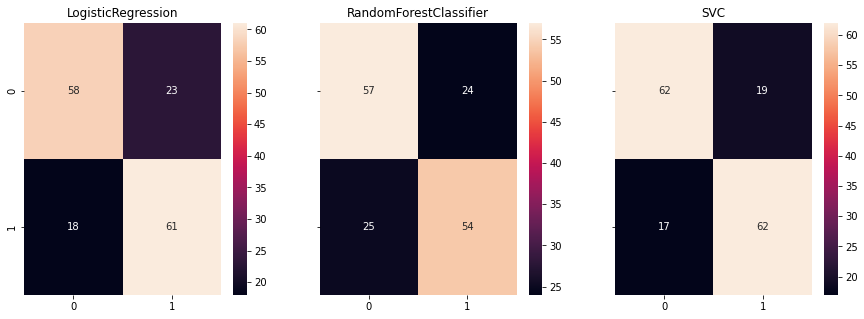

In [27]:
evaluate_predictions(pca_fd_train_df, pca_fd_test_df, pca_fd_train_y, pca_fd_test_y)

# BENCHMARK - REGION OF INTEREST

In [28]:
montgomery_masks = extract_mask_path(filelist_montgommery, 'montgomery')
shenzen_masks = extract_mask_path(filelist_shenzen, 'shenzen')

100%|██████████| 662/662 [00:00<00:00, 219219.11it/s]


In [29]:
# Create dataframe
montgomery_data = pd.DataFrame(filelist_montgommery, columns=['filepath'])
montgomery_data['maskpath'] = montgomery_masks

shenzen_data = pd.DataFrame(filelist_shenzen, columns=['filepath'])
shenzen_data['maskpath'] = shenzen_masks

In [30]:
full_data_masked = pd.concat([montgomery_data,shenzen_data])

In [31]:
full_list_masked = full_data_masked['filepath'].tolist()

In [32]:
labels_masked = extract_label(full_list_masked)

100%|██████████| 800/800 [00:00<00:00, 318504.34it/s]


In [33]:
full_data_masked['target'] = labels_masked

In [34]:
def remove_missing_mask_data(df):
    df = df.reset_index(drop=True)
    
    for i in range(df.shape[0]):
        try:
            im_path = df.loc[i,'maskpath']
            img = cv2.imread(im_path)
        except cv2.error as e:
            img = None
            
        if img is None:
            df.drop([i], inplace=True)
            
    return df

In [35]:
full_data_masked = remove_missing_mask_data(full_data_masked)

In [36]:
full_data_masked

filepath  \
0    ../input/pulmonary-chest-xray-abnormalities/Mo...   
1    ../input/pulmonary-chest-xray-abnormalities/Mo...   
2    ../input/pulmonary-chest-xray-abnormalities/Mo...   
3    ../input/pulmonary-chest-xray-abnormalities/Mo...   
4    ../input/pulmonary-chest-xray-abnormalities/Mo...   
..                                                 ...   
795  ../input/pulmonary-chest-xray-abnormalities/Ch...   
796  ../input/pulmonary-chest-xray-abnormalities/Ch...   
797  ../input/pulmonary-chest-xray-abnormalities/Ch...   
798  ../input/pulmonary-chest-xray-abnormalities/Ch...   
799  ../input/pulmonary-chest-xray-abnormalities/Ch...   

                                         maskpath target  
0      ../input/montgomery-mask/MCUCXR_0017_0.png      0  
1      ../input/montgomery-mask/MCUCXR_0020_0.png      0  
2      ../input/montgomery-mask/MCUCXR_0030_0.png      0  
3      ../input/montgomery-mask/MCUCXR_0013_0.png      0  
4      ../input/montgomery-mask/MCUCXR_0354_1.png      1  
..                                            ...    ...  
795  ../input/shenzen-mask/CHNCXR_0321_0_mask.png      0  
796  ../input/shenzen-mask/CHNCXR_0080_0_mask.png      0  
797  ../input/shenzen-mask/CHNCXR_0569_1_mask.png      1  
798  ../input/shenzen-mask/CHNCXR_0107_0_mask.png      0  
799  ../input/shenzen-mask/CHNCXR_0054_0_mask.png      0  

[704 rows x 3 columns]

In [37]:
full_labels_masked = pd.DataFrame(full_data_masked.pop('target'), columns=['target'])

In [38]:
def get_mask_boundary_coords(mask_path):    
    mask = cv2.imread(mask_path)
    
    coords = np.nonzero(mask)    
    yt = np.min(coords[0])
    yb = np.max(coords[0])
    xl = np.min(coords[1])
    xr = np.max(coords[1])
    
    border = {'yt': yt, 'yb': yb, 'xl': xl, 'xr': xr}
    
    return border

In [39]:
def get_region_of_interest(img_path, mask_path, resize=(128,128)):
    img = cv2.imread(img_path)
    border_dict = get_mask_boundary_coords(mask_path)
    
    cropped_img = img[border_dict['yt']:border_dict['yb'], border_dict['xl']:border_dict['xr']]
    resized_img = cv2.resize(cropped_img, resize, interpolation = cv2.INTER_AREA)

    if(len(resized_img.shape) < 3):
        resized_img_gray = resized_img[:,:]
    else:
        resized_img_gray = resized_img[:,:,0]
    
    return(resized_img_gray)
    

In [40]:
def plot_cropped_images(image_dataframe, rows=4, columns=4, figsize=(16, 16), resize=(128,128)):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        im_path = image_dataframe.loc[i,'filepath']
        mask_path = image_dataframe.loc[i,'maskpath']
        
        
        img = cv2.imread(im_path)
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Original "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Cropped "+str(i+1))
        resized_img = get_region_of_interest(im_path, mask_path)
        plt.imshow(resized_img, cmap='gray')
        nth_subplot += 1
    
    plt.show()

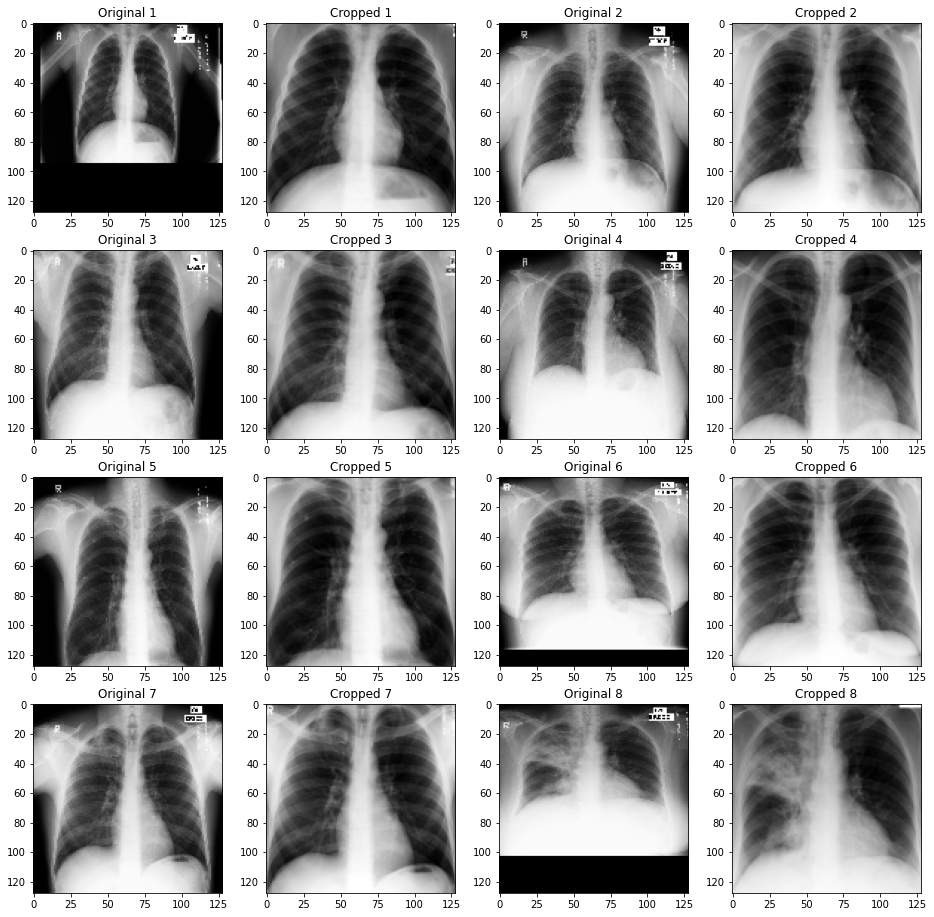

In [41]:
plot_cropped_images(full_data_masked, rows=4, columns=2)

In [42]:
def flatten_masked_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        mask_path = df.loc[i,'maskpath']
        resized_img = get_region_of_interest(im_path, mask_path)
        flat_img = resized_img.flatten().tolist()        
        current = pd.DataFrame(flat_img).T
        result  = result.append(current)
    
    return(result)

In [43]:
full_data_masked_flat = flatten_masked_dataframe(full_data_masked)

100%|██████████| 704/704 [05:09<00:00,  2.27it/s]


In [44]:
full_data_masked_flat

0      1      2      3      4      5      6      7      8      9      ...  \
0     148    146    148    161    180    170    165    158    160    169  ...   
0     141    150    150    155    153    147    143    141    139    130  ...   
0     174    171    166    161    159    158    159    159    160    162  ...   
0      41     43     44     45     46     46     46     46     46     46  ...   
0     154    151    149    151    160    162    160    162    156    134  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
0     145    146    146    146    147    147    146    145    144    144  ...   
0     181    185    187    184    180    178    177    183    198    190  ...   
0     225    234    230    214    209    212    209    205    210    223  ...   
0     134    135    135    135    135    138    137    139    139    140  ...   
0     104    109    111    114    116    118    120    122    125    129  ...   

    16374  16375  16376  16377  16378  16379  16380  16381  16382  16383  
0     142    132    121    110     94     88     86    118    121    112  
0     193    193    192    190    188    184    180    162    147    141  
0     168    164    155    148    140    141    143    141    136    100  
0     218    218    215    214    217    221    222    225    225    228  
0      36     37     48     53     59     63     60     68    123    136  
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
0     213    213    215    216    216    214    209    203    199    203  
0     203    202    204    206    208    214    213    210    209    206  
0     211    211    205    200    196    186    178    174    161    176  
0     226    225    224    224    216    208    203    201    201    212  
0     214    212    206    197    176    152    166    186    195    193  

[704 rows x 16384 columns]

In [45]:
masked_train_df,masked_test_df,masked_train_y,masked_test_y = train_test_split(full_data_masked_flat, 
                                                                               full_labels_masked['target'], 
                                                                               stratify = full_labels_masked['target'],
                                                                               test_size  = 0.2, 
                                                                               random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Model: LogisticRegression >> CV Score: 0.74, Test Accuracy: 0.73, Test AUC: 0.73


{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.79, Test Accuracy: 0.77, Test AUC: 0.77


{'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Model: SVC >> CV Score: 0.78, Test Accuracy: 0.77, Test AUC: 0.77




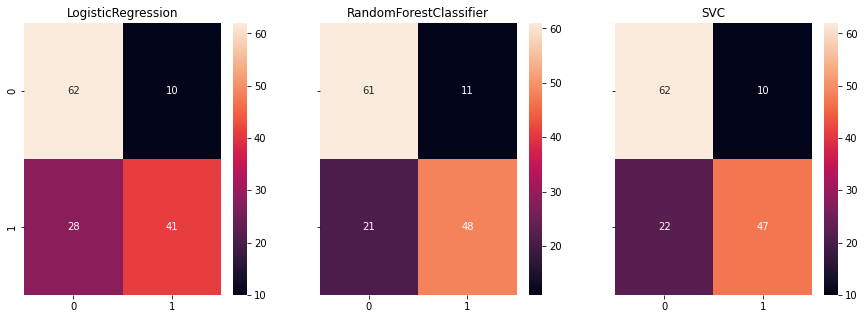

In [46]:
evaluate_predictions(masked_train_df, masked_test_df, masked_train_y, masked_test_y)

# BENCHMARK - REGION OF INTEREST AFTER PCA FEATURE REDUCTION

In [47]:
min_max_scaler = MinMaxScaler()
full_data_scaled_flat = min_max_scaler.fit_transform(full_data_masked_flat)

In [48]:
pca = decomposition.PCA(n_components=500)
full_data_pca_flat = pca.fit_transform(full_data_scaled_flat)

In [49]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [50]:
full_data_norm_flat = normalize_data(full_data_pca_flat)

In [51]:
full_data_norm_flat.shape

(704, 500)

In [52]:
pca_train_df,pca_test_df,pca_train_y,pca_test_y = train_test_split(full_data_norm_flat,
                                                                   full_labels_masked['target'],
                                                                   stratify = full_labels_masked['target'],
                                                                   test_size  = 0.2,
                                                                   random_state = 25)

{'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Model: LogisticRegression >> CV Score: 0.74, Test Accuracy: 0.72, Test AUC: 0.72


{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.75, Test Accuracy: 0.74, Test AUC: 0.74


{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Model: SVC >> CV Score: 0.77, Test Accuracy: 0.74, Test AUC: 0.74




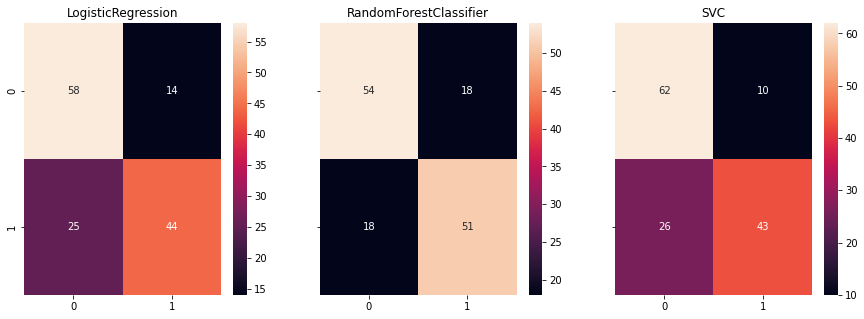

In [53]:
evaluate_predictions(pca_train_df, pca_test_df, pca_train_y, pca_test_y)

# BENCHMARK - MASKED LUNGS AREA

In [54]:
montgomery_masks = extract_mask_path(filelist_montgommery, 'montgomery')
shenzen_masks = extract_mask_path(filelist_shenzen, 'shenzen')

100%|██████████| 662/662 [00:00<00:00, 150666.30it/s]


In [55]:
# Create dataframe
montgomery_data = pd.DataFrame(filelist_montgommery, columns=['filepath'])
montgomery_data['maskpath'] = montgomery_masks

shenzen_data = pd.DataFrame(filelist_shenzen, columns=['filepath'])
shenzen_data['maskpath'] = shenzen_masks

In [56]:
full_data_masked = pd.concat([montgomery_data,shenzen_data])

In [57]:
full_list_masked = full_data_masked['filepath'].tolist()

In [58]:
labels_masked = extract_label(full_list_masked)

100%|██████████| 800/800 [00:00<00:00, 311989.14it/s]


In [59]:
full_data_masked['target'] = labels_masked

In [60]:
full_data_masked_clean = remove_missing_mask_data(full_data_masked)

In [61]:
full_data_masked_clean

filepath  \
0    ../input/pulmonary-chest-xray-abnormalities/Mo...   
1    ../input/pulmonary-chest-xray-abnormalities/Mo...   
2    ../input/pulmonary-chest-xray-abnormalities/Mo...   
3    ../input/pulmonary-chest-xray-abnormalities/Mo...   
4    ../input/pulmonary-chest-xray-abnormalities/Mo...   
..                                                 ...   
795  ../input/pulmonary-chest-xray-abnormalities/Ch...   
796  ../input/pulmonary-chest-xray-abnormalities/Ch...   
797  ../input/pulmonary-chest-xray-abnormalities/Ch...   
798  ../input/pulmonary-chest-xray-abnormalities/Ch...   
799  ../input/pulmonary-chest-xray-abnormalities/Ch...   

                                         maskpath target  
0      ../input/montgomery-mask/MCUCXR_0017_0.png      0  
1      ../input/montgomery-mask/MCUCXR_0020_0.png      0  
2      ../input/montgomery-mask/MCUCXR_0030_0.png      0  
3      ../input/montgomery-mask/MCUCXR_0013_0.png      0  
4      ../input/montgomery-mask/MCUCXR_0354_1.png      1  
..                                            ...    ...  
795  ../input/shenzen-mask/CHNCXR_0321_0_mask.png      0  
796  ../input/shenzen-mask/CHNCXR_0080_0_mask.png      0  
797  ../input/shenzen-mask/CHNCXR_0569_1_mask.png      1  
798  ../input/shenzen-mask/CHNCXR_0107_0_mask.png      0  
799  ../input/shenzen-mask/CHNCXR_0054_0_mask.png      0  

[704 rows x 3 columns]

In [62]:
full_masked_labels = pd.DataFrame(full_data_masked_clean.pop('target'), columns=['target'])

In [63]:
def get_masked_image(img_path, mask_path, resize=(256,256)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, resize)

        
    if(len(img.shape)<3):
        gray = img[:,:]
    else:
        gray = img[:,:,0]

    
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, resize)
    mask_int8 = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    if(len(mask_int8.shape)<3):
        mask_int8 = mask_int8[:,:]
    else:
        mask_int8 = mask_int8[:,:,0]
    
    masked_img =  cv2.bitwise_and(gray, gray, mask=mask_int8)
    
    return masked_img

In [64]:
def plot_masked_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(256,256), preprocessing=None):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        img = cv2.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
        
        if preprocessing:
            img = preprocessing(img)
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        masked_img =  get_masked_image(image_dataframe.loc[i,'filepath'], 
                                       image_dataframe.loc[i,'maskpath'],
                                       resize=resize)
        
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Masked "+str(i+1))
        plt.imshow(masked_img, cmap='gray') 
        nth_subplot += 1
    
    plt.show()

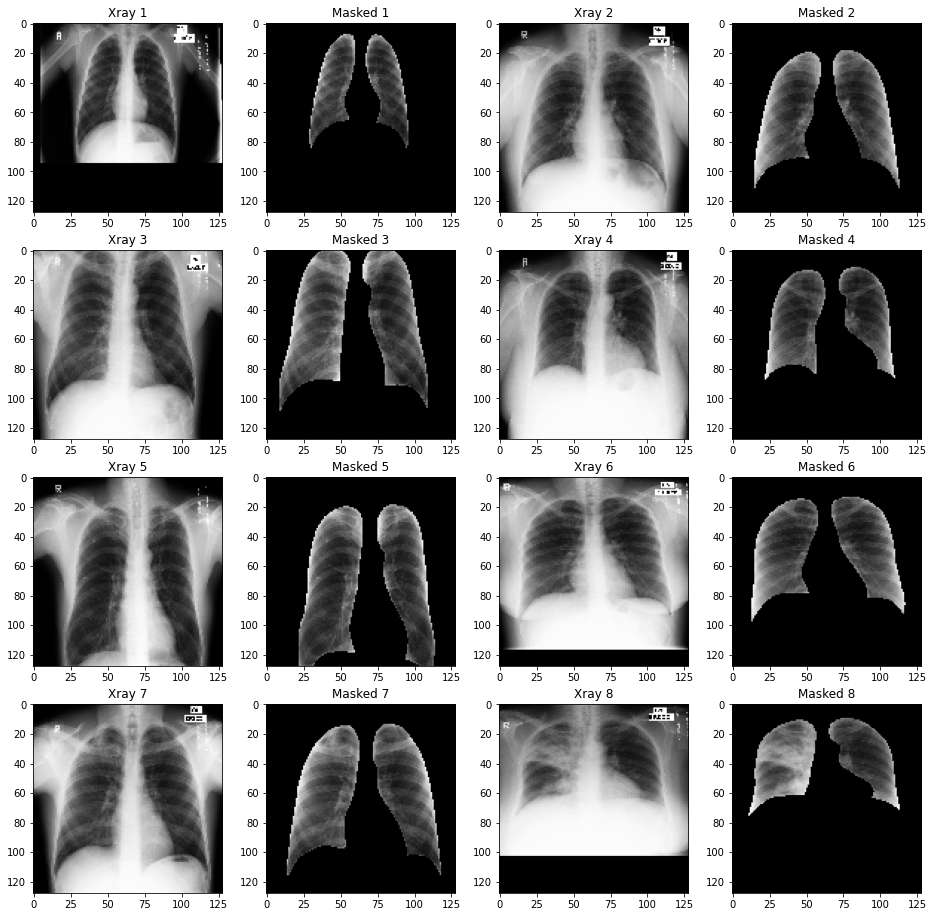

In [65]:
plot_masked_images(full_data_masked_clean, rows=4, columns = 2, figsize = (16, 16), resize=(128,128))

In [66]:
def load_masked_image(image, image_dims = (128,128), grayscale=True, flatten=True, interpolation = cv2.INTER_AREA):
    
    resized_image = cv2.resize(image, image_dims, interpolation = interpolation)
    
    if grayscale:
        if(len(resized_image.shape)<3):
            resized_image = resized_image[:,:]
        else:
            resized_image = resized_image[:,:,0]
    
    
    if flatten:
        resized_image = resized_image.flatten()
    
    return(resized_image)

In [67]:
def flatten_masked_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        mask_path = df.loc[i,'maskpath']
        current = get_masked_image(im_path, mask_path,resize=(128,128))

        current = load_masked_image(current).tolist()        
        current = pd.DataFrame(current).T
        result  = result.append(current)
    
    return(result)

In [68]:
full_data_masked_flat = flatten_masked_dataframe(full_data_masked_clean)

100%|██████████| 704/704 [02:11<00:00,  5.34it/s]


In [69]:
full_data_masked_flat

0      1      2      3      4      5      6      7      8      9      ...  \
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   
0       0      0      0      0      0      0      0      0      0      0  ...   

    16374  16375  16376  16377  16378  16379  16380  16381  16382  16383  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  
0       0      0      0      0      0      0      0      0      0      0  

[704 rows x 16384 columns]

In [70]:
masked_train_df,masked_test_df,masked_train_y,masked_test_y = train_test_split(full_data_masked_flat, 
                                                                               full_labels_masked['target'], 
                                                                               stratify = full_labels_masked['target'],
                                                                               test_size  = 0.2, 
                                                                               random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Model: LogisticRegression >> CV Score: 0.67, Test Accuracy: 0.64, Test AUC: 0.64


{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.77, Test Accuracy: 0.76, Test AUC: 0.76


{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Model: SVC >> CV Score: 0.68, Test Accuracy: 0.65, Test AUC: 0.64




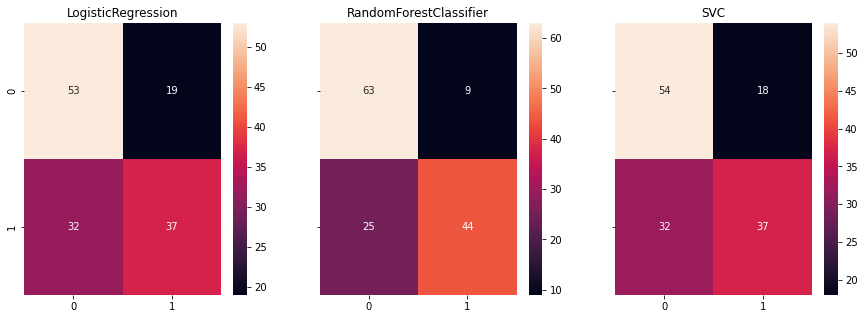

In [71]:
evaluate_predictions(masked_train_df, masked_test_df, masked_train_y, masked_test_y)

# BENCHMARK - MASKED LUNGS AREA AFTER PCA FEATURE REDUCTION

In [72]:
min_max_scaler = MinMaxScaler()
full_data_scaled_flat = min_max_scaler.fit_transform(full_data_masked_flat)

In [73]:
pca = decomposition.PCA(n_components=500)
full_data_pca_flat = pca.fit_transform(full_data_scaled_flat)
    

In [74]:
full_data_norm_flat = normalize_data(full_data_pca_flat)

In [75]:
full_data_norm_flat.shape

(704, 500)

In [76]:
pca_train_df,pca_test_df,pca_train_y,pca_test_y = train_test_split(full_data_norm_flat,
                                                                   full_labels_masked['target'],
                                                                   stratify = full_labels_masked['target'],
                                                                   test_size  = 0.2,
                                                                   random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Model: LogisticRegression >> CV Score: 0.66, Test Accuracy: 0.66, Test AUC: 0.66


{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}
Model: RandomForestClassifier >> CV Score: 0.58, Test Accuracy: 0.57, Test AUC: 0.57


{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Model: SVC >> CV Score: 0.69, Test Accuracy: 0.69, Test AUC: 0.69




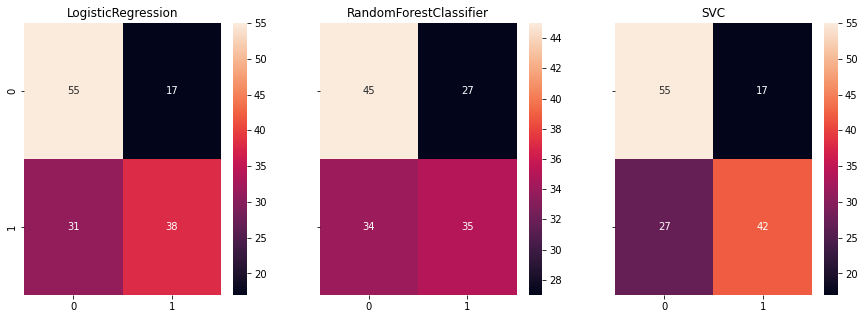

In [77]:
evaluate_predictions(pca_train_df, pca_test_df, pca_train_y, pca_test_y)

# RESULT

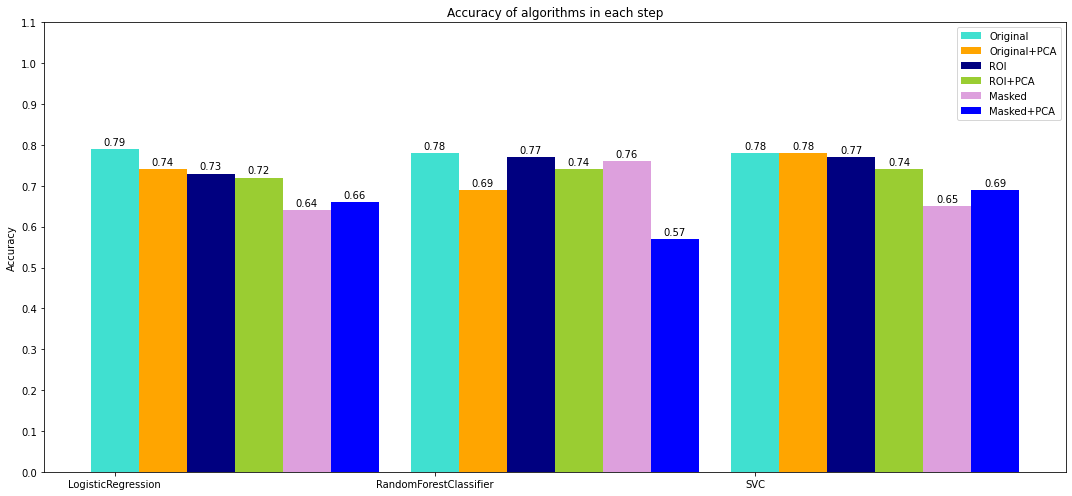

In [78]:
# Now we will plot the accuracies obtained in each step

labels = ['LogisticRegression', 'RandomForestClassifier', 'SVC']
STEPS =  []

for lr,rf,svc in zip(LR_accuracies,RF_accuracies, SVC_accuracies):
    STEPS.append([lr,rf,svc])

step_original = STEPS[0]
step_original_pca = STEPS[1]
step_cropped = STEPS[2]
step_cropped_pca = STEPS[3]
step_masked = STEPS[4]
step_masked_pca = STEPS[5]


index = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(index, step_original, width, label='Original', color='turquoise')
rects2 = ax.bar(index + width, step_original_pca, width, label='Original+PCA', color='orange')
rects3 = ax.bar(index + width*2, step_cropped, width, label='ROI', color='navy')
rects4 = ax.bar(index + width*3, step_cropped_pca, width, label='ROI+PCA', color='yellowgreen')
rects5 = ax.bar(index + width*4, step_masked, width, label='Masked', color='plum')
rects6 = ax.bar(index + width*5, step_masked_pca, width, label='Masked+PCA', color='blue')


ax.set_title('Accuracy of algorithms in each step')
ax.set_xticks(index, labels)
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0, 1.2, 0.1))
ax.legend()

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)
ax.bar_label(rects5, padding=2)
ax.bar_label(rects6, padding=2)

fig.tight_layout()

plt.show()

# APPLYING OTHER PREPROCESSING METHODS:
From the above experiments we see the result of focusing on region of interest. Now, we will try 4 different preprocess methods on the images and compare the results. For each method first we did data visualization and then transformed our data,trained different models and compared the output.

## 1. HISTOGRAM EQUALIZATION:

In [79]:
def plot_histo_images(image_dataframe, rows=4, columns=4, figsize=(16, 16), resize=(128,128)):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        im_path = image_dataframe.loc[i,'filepath']
        mask_path = image_dataframe.loc[i,'maskpath']
        
        
        img = cv2.imread(im_path)
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Original "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Cropped "+str(i+1))
        resized_img = get_region_of_interest(im_path, mask_path)
        resized_img = cv2.equalizeHist(resized_img)
        plt.imshow(resized_img, cmap='gray')
        nth_subplot += 1
    
    plt.show()

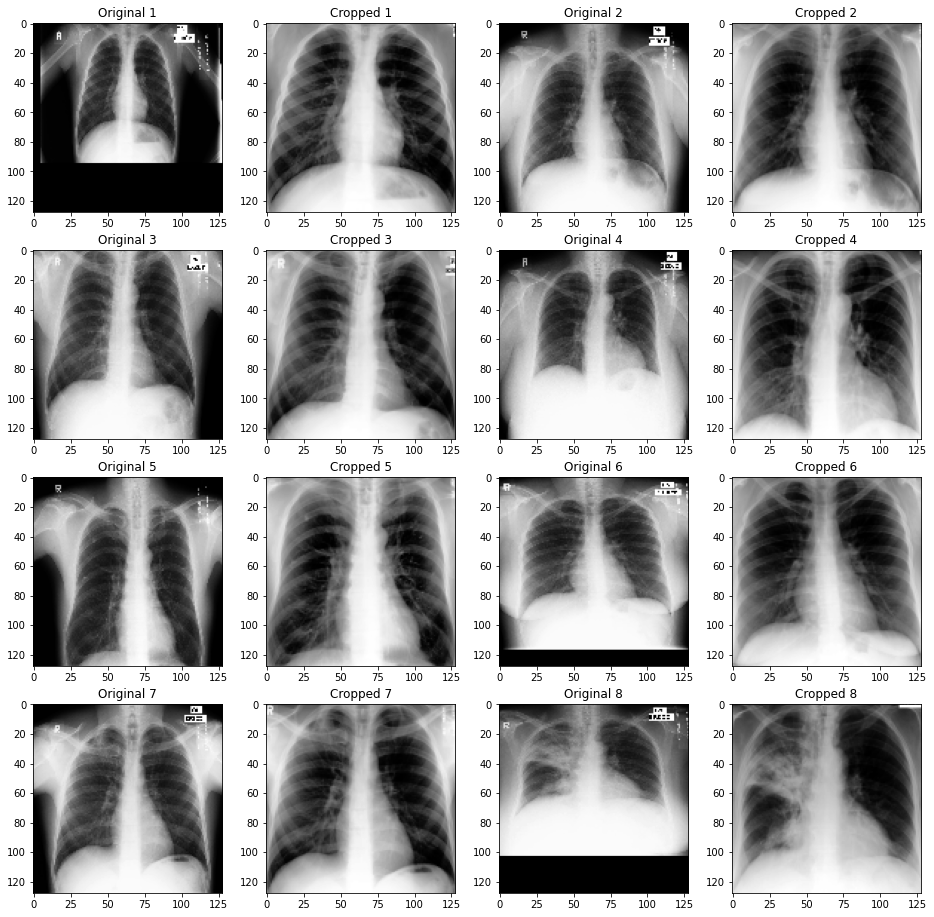

In [80]:
plot_histo_images(full_data_masked_clean, rows=4, columns = 2, figsize = (16, 16), resize=(128,128))

In [81]:
def flatten_masked_hist_equ_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        mask_path = df.loc[i,'maskpath']
        resized_img = get_region_of_interest(im_path, mask_path)
        
        resized_img = cv2.equalizeHist(resized_img)
        flat_img = resized_img.flatten().tolist()        
        current = pd.DataFrame(flat_img).T
        result  = result.append(current)
    
    return(result)

In [82]:
full_data_masked_hist_flat = flatten_masked_hist_equ_dataframe(full_data_masked_clean)

100%|██████████| 704/704 [05:03<00:00,  2.32it/s]


In [83]:
hist_train_df,hist_test_df,hist_train_y,hist_test_y = train_test_split(full_data_masked_hist_flat, 
                                                                               full_labels_masked['target'], 
                                                                               stratify = full_labels_masked['target'],
                                                                               test_size  = 0.2, 
                                                                               random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Model: LogisticRegression >> CV Score: 0.67, Test Accuracy: 0.64, Test AUC: 0.64


{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.77, Test Accuracy: 0.74, Test AUC: 0.74


{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Model: SVC >> CV Score: 0.68, Test Accuracy: 0.65, Test AUC: 0.64




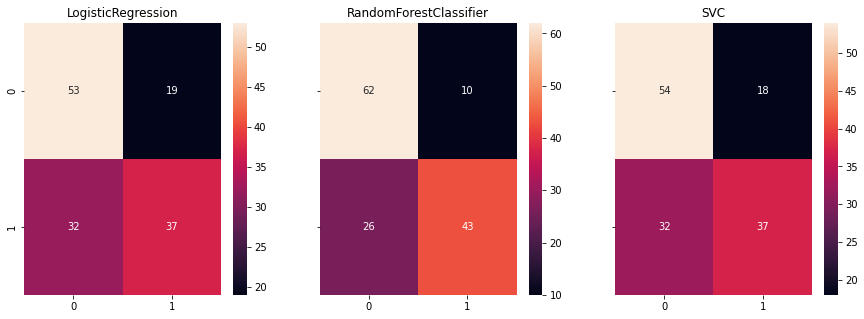

In [84]:
evaluate_predictions(masked_train_df, masked_test_df, masked_train_y, masked_test_y)

## 2. HISTOGRAM EQUALIZATION AND GAUSSIAN BLUR

In [85]:
def plot_histoblur_images(image_dataframe, rows=4, columns=4, figsize=(16, 16), resize=(128,128)):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        im_path = image_dataframe.loc[i,'filepath']
        mask_path = image_dataframe.loc[i,'maskpath']
        
        
        img = cv2.imread(im_path)
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Original "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Cropped "+str(i+1))
        resized_img = get_region_of_interest(im_path, mask_path)
        resized_img = cv2.equalizeHist(resized_img)
        resized_img = cv2.GaussianBlur(resized_img, (3, 3), 0)
        plt.imshow(resized_img, cmap='gray')
        nth_subplot += 1
    
    plt.show()

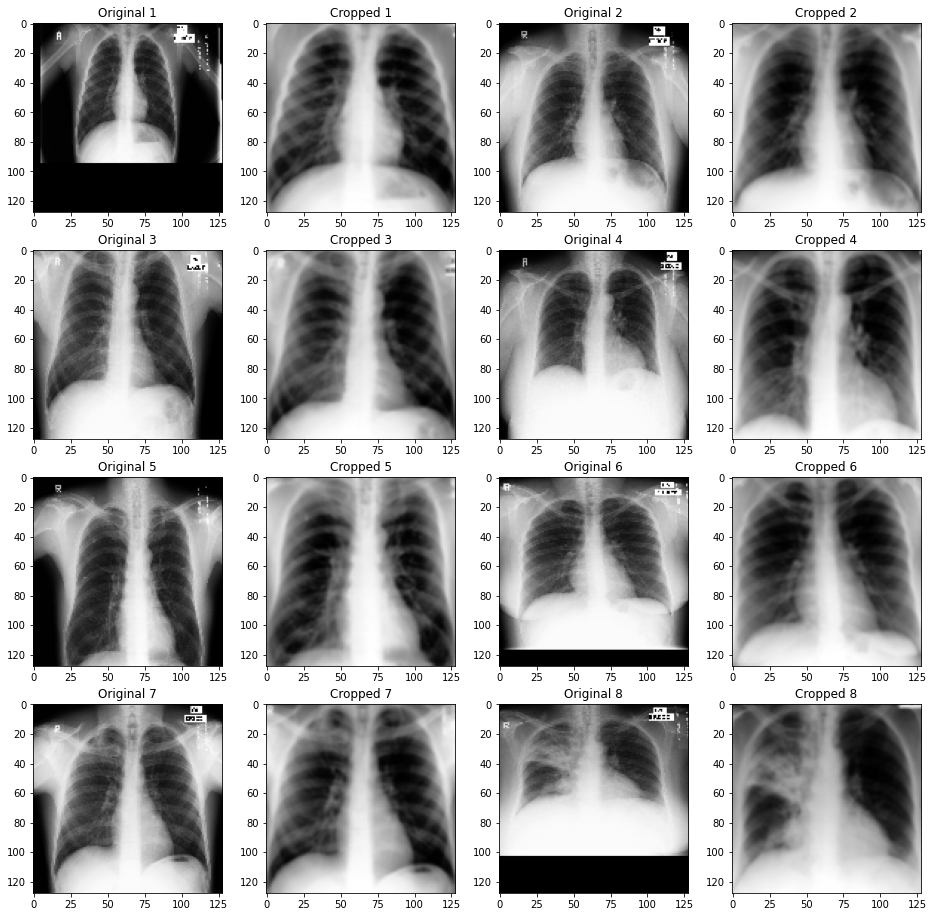

In [86]:
plot_histoblur_images(full_data_masked_clean, rows=4, columns = 2, figsize = (16, 16), resize=(128,128))

In [87]:
def flatten_masked_hist_blur_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        mask_path = df.loc[i,'maskpath']
        resized_img = get_region_of_interest(im_path, mask_path)
        resized_img = cv2.equalizeHist(resized_img)
        resized_img = cv2.GaussianBlur(resized_img, (3, 3), 0)
        flat_img = resized_img.flatten().tolist()  
        current = pd.DataFrame(flat_img).T
        result  = result.append(current)
    
    return(result)

In [88]:
full_data_masked_hist_blur_flat = flatten_masked_hist_blur_dataframe(full_data_masked_clean)

100%|██████████| 704/704 [05:02<00:00,  2.33it/s]


In [89]:
hist_blur_train_df,hist_blur_test_df,hist_blur_train_y,hist_blur_test_y = train_test_split(full_data_masked_hist_blur_flat, 
                                                                               full_labels_masked['target'], 
                                                                               stratify = full_labels_masked['target'],
                                                                               test_size  = 0.2, 
                                                                               random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Model: LogisticRegression >> CV Score: 0.75, Test Accuracy: 0.74, Test AUC: 0.74


{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.76, Test Accuracy: 0.77, Test AUC: 0.77


{'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Model: SVC >> CV Score: 0.76, Test Accuracy: 0.77, Test AUC: 0.77




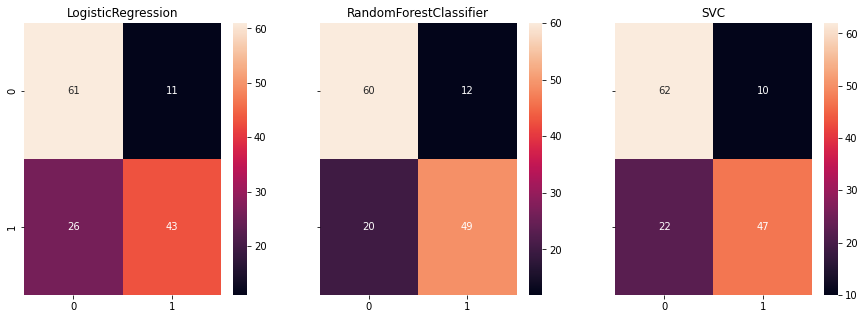

In [90]:
evaluate_predictions(hist_blur_train_df,hist_blur_test_df,hist_blur_train_y,hist_blur_test_y)

## 3. HISTORGRAM EQUALIZATION AND BILATERAL FILTER

In [91]:
def plot_histobilateral_images(image_dataframe, rows=4, columns=4, figsize=(16, 16), resize=(128,128)):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        im_path = image_dataframe.loc[i,'filepath']
        mask_path = image_dataframe.loc[i,'maskpath']
        
        
        img = cv2.imread(im_path)
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Original "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Cropped "+str(i+1))
        resized_img = get_region_of_interest(im_path, mask_path)
        resized_img = cv2.equalizeHist(resized_img)
        resized_img = cv2.bilateralFilter(resized_img, 3, 21, 21)
        plt.imshow(resized_img, cmap='gray')
        nth_subplot += 1
    
    plt.show()

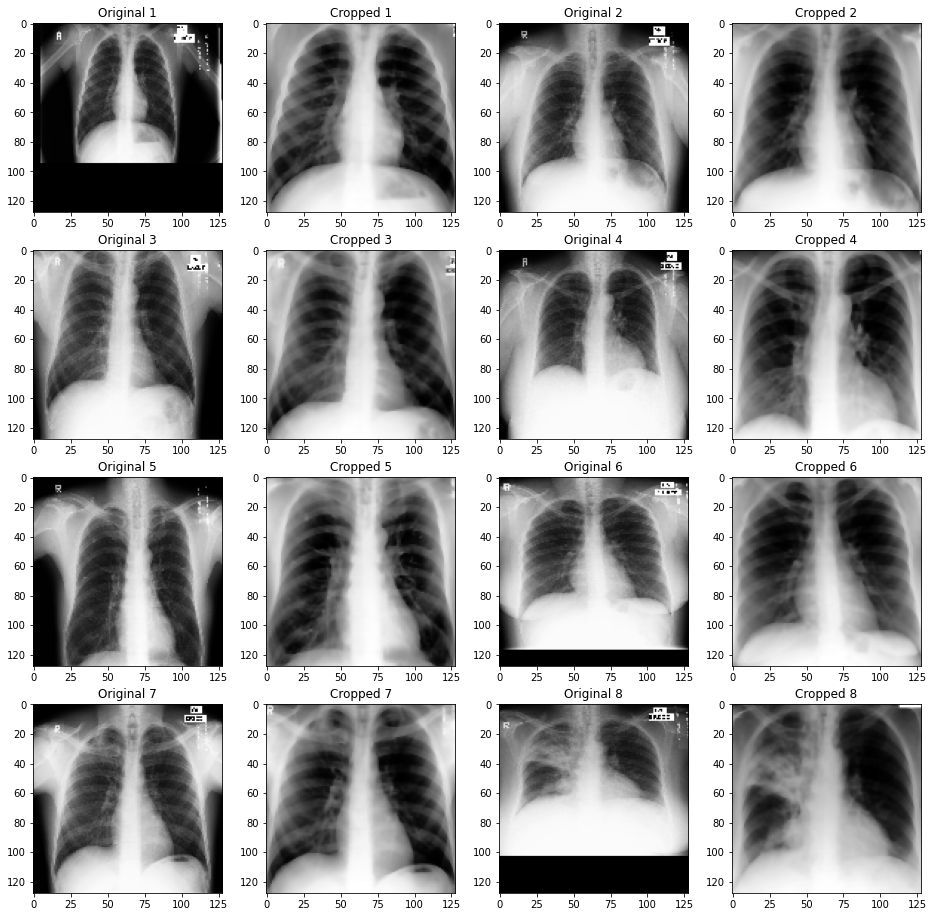

In [92]:
plot_histobilateral_images(full_data_masked_clean, rows=4, columns = 2, figsize = (16, 16), resize=(128,128))

In [93]:
def flatten_masked_hist_bilateral_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        mask_path = df.loc[i,'maskpath']
        resized_img = get_region_of_interest(im_path, mask_path)
        resized_img = cv2.equalizeHist(resized_img)
        resized_img = cv2.bilateralFilter(resized_img, 3, 21, 21)
        flat_img = resized_img.flatten().tolist()  
        current = pd.DataFrame(flat_img).T
        result  = result.append(current)
    
    return(result)

In [94]:
full_data_masked_hist_bilateral_flat = flatten_masked_hist_bilateral_dataframe(full_data_masked_clean)

100%|██████████| 704/704 [04:59<00:00,  2.35it/s]


In [95]:
hist_bilateral_train_df,hist_bilateral_test_df,hist_bilateral_train_y,hist_bilateral_test_y = train_test_split(full_data_masked_hist_bilateral_flat, 
                                                                               full_labels_masked['target'], 
                                                                               stratify = full_labels_masked['target'],
                                                                               test_size  = 0.2, 
                                                                               random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Model: LogisticRegression >> CV Score: 0.75, Test Accuracy: 0.74, Test AUC: 0.74


{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.77, Test Accuracy: 0.77, Test AUC: 0.76


{'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Model: SVC >> CV Score: 0.76, Test Accuracy: 0.79, Test AUC: 0.79




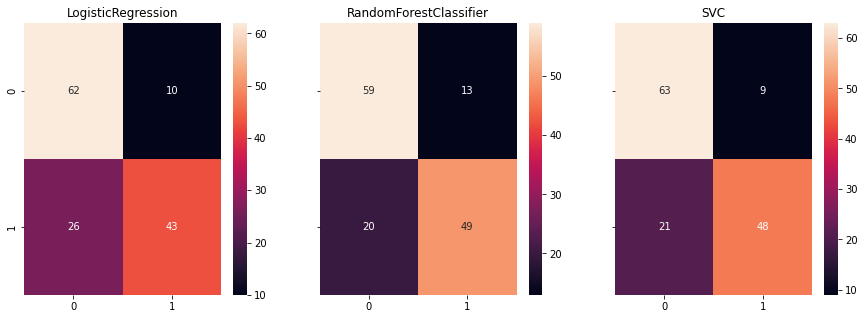

In [96]:
evaluate_predictions(hist_bilateral_train_df,hist_bilateral_test_df,hist_bilateral_train_y,hist_bilateral_test_y)

## 4. ADAPTIVE MASK:

In [97]:
def plot_adoptive_images(image_dataframe, rows=4, columns=4, figsize=(16, 16), resize=(128,128)):

    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []
    nth_subplot = 1

    for i in range(rows * columns):
        im_path = image_dataframe.loc[i,'filepath']
        mask_path = image_dataframe.loc[i,'maskpath']
        
        
        img = cv2.imread(im_path)
        img = cv2.resize(img, resize)
        
        if(len(img.shape)<3):
            gray = img[:,:]
        else:
            gray = img[:,:,0]
                  
            
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Original "+str(i+1))
        plt.imshow(gray, cmap='gray')        
        nth_subplot += 1
        
        ax.append(fig.add_subplot(rows, columns*2, nth_subplot))
        ax[-1].set_title("Cropped "+str(i+1))
        resized_img = get_region_of_interest(im_path, mask_path)
        (T, resized_img) = cv2.threshold(resized_img, 170, 255, cv2.THRESH_BINARY)

        plt.imshow(resized_img, cmap='gray')
        nth_subplot += 1
    
    plt.show()

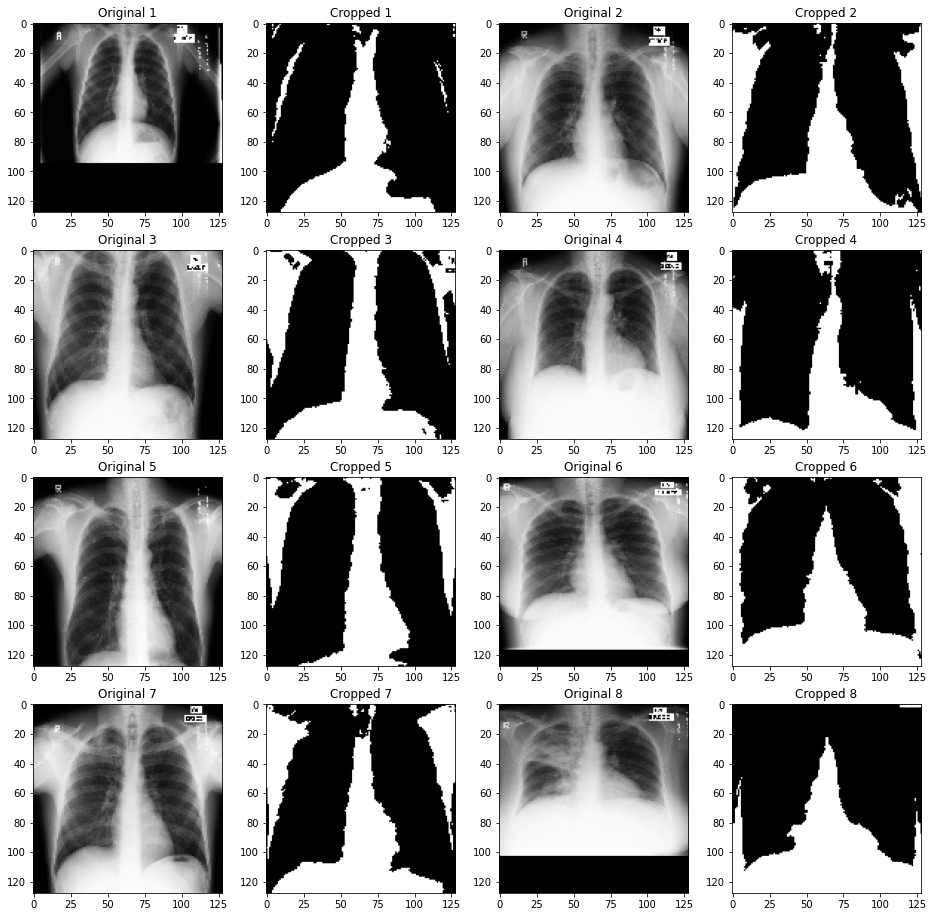

In [98]:
plot_adoptive_images(full_data_masked_clean, rows=4, columns = 2, figsize = (16, 16), resize=(128,128))

In [99]:
def flatten_masked_adoptive_dataframe(df):
    df = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        mask_path = df.loc[i,'maskpath']
        resized_img = get_region_of_interest(im_path, mask_path)
        (T, resized_img) = cv2.threshold(resized_img, 170, 255, cv2.THRESH_BINARY)

        flat_img = resized_img.flatten().tolist()  
        current = pd.DataFrame(flat_img).T
        result  = result.append(current)
    
    return(result)

In [100]:
full_data_masked_adoptive_flat = flatten_masked_adoptive_dataframe(full_data_masked_clean)

100%|██████████| 704/704 [05:02<00:00,  2.32it/s]


In [101]:
adoptive_train_df,adoptive_test_df,adoptive_train_y,adoptive_test_y = train_test_split(full_data_masked_adoptive_flat, 
                                                                               full_labels_masked['target'], 
                                                                               stratify = full_labels_masked['target'],
                                                                               test_size  = 0.2, 
                                                                               random_state = 25)

{'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Model: LogisticRegression >> CV Score: 0.75, Test Accuracy: 0.67, Test AUC: 0.67


{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}
Model: RandomForestClassifier >> CV Score: 0.76, Test Accuracy: 0.75, Test AUC: 0.75


{'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
Model: SVC >> CV Score: 0.78, Test Accuracy: 0.72, Test AUC: 0.71




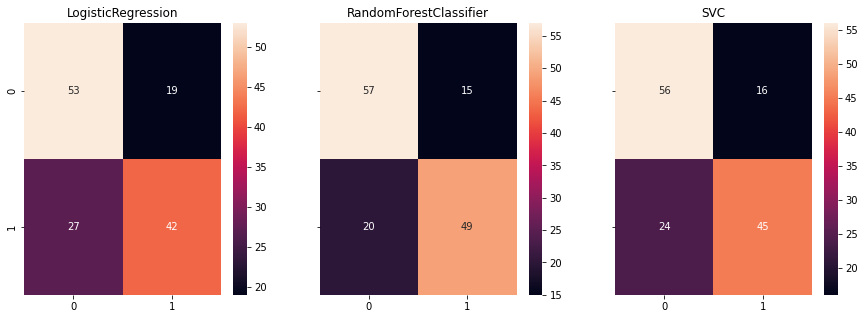

In [102]:
evaluate_predictions(adoptive_train_df,adoptive_test_df,adoptive_train_y,adoptive_test_y)

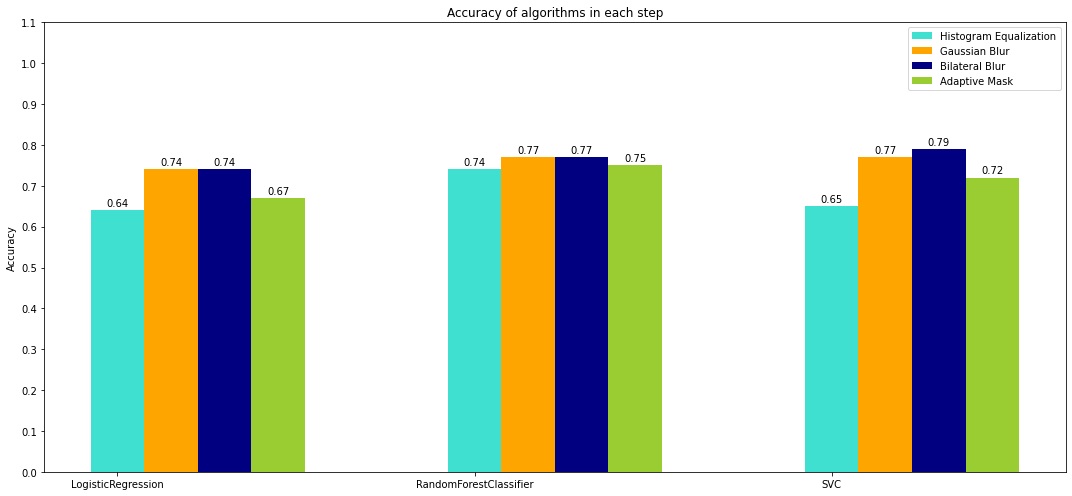

In [103]:
# Now we will plot the accuracies obtained in each step

labels = ['LogisticRegression', 'RandomForestClassifier', 'SVC']
STEPS =  []

for lr,rf,svc in zip(LR_accuracies,RF_accuracies, SVC_accuracies):
    STEPS.append([lr,rf,svc])

step_hist = STEPS[6]
step_gaussian = STEPS[7]
step_bilateral = STEPS[8]
step_adaptive = STEPS[9]



index = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

rects1 = ax.bar(index, step_hist, width, label='Histogram Equalization', color='turquoise')
rects2 = ax.bar(index + width, step_gaussian, width, label='Gaussian Blur', color='orange')
rects3 = ax.bar(index + width*2, step_bilateral, width, label='Bilateral Blur', color='navy')
rects4 = ax.bar(index + width*3, step_adaptive, width, label='Adaptive Mask', color='yellowgreen')


ax.set_title('Accuracy of algorithms in each step')
ax.set_xticks(index, labels)
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0, 1.2, 0.1))
ax.legend()

ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)
ax.bar_label(rects3, padding=2)
ax.bar_label(rects4, padding=2)

fig.tight_layout()

plt.show()